# 3 Klassifikation des Objekttyps (1/4)
Ziel dieser Aufgabe ist es, ein Modell zu erstellen, welches durch beliebige Metriken eine akkurate Vorhersage über den Typ der Immobilie erstellt.

Wir vergleichen hier drei Ansätze miteinander

## Importieren der benötigten Libraries und Daten

In [121]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, matthews_corrcoef, roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from utils.gabonisator import Gabonisator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm

Die Daten beziehen wir aus unserem Data Repository auf GitHub.

In [4]:
# read clean data + plz data
data = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean.csv"
)
data = data[["price", "zip_code", "living_space", "rooms", "type"]]
plz = pd.read_csv(
    "https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/plz_data.csv"
)

# Helferfunktionen

In [181]:
class Evaluator:
  
  def __init__(self, y_true, y_est, classes):
    self.y_true = y_true
    self.y_est = y_est
    self.classes = classes
    self.fpr = dict()
    self.tpr = dict()
    self.roc_auc = dict()
  
  def calculate_roc_auc(self, model, X_true):
    self.model = model
    self.X_true = X_true
    self.y_true = label_binarize(self.y_true, classes=self.classes)
    self.y_score = self.model.predict_proba(self.X_true)
    self.n_classes = len(self.classes)

    for i in range(self.classes.shape[0]):
      self.fpr[i], self.tpr[i], _ = roc_curve(self.y_true[:, i], self.y_score[:, i])
      self.roc_auc[i] = auc(self.fpr[i], self.tpr[i])

    # Compute micro-average ROC curve and ROC area
    self.fpr["micro"], self.tpr["micro"], _ = roc_curve(self.y_true.ravel(), self.y_score.ravel())
    self.roc_auc["micro"] = auc(self.fpr["micro"], self.tpr["micro"])


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([self.fpr[i] for i in range(self.n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(self.n_classes):
        mean_tpr += np.interp(all_fpr, self.fpr[i], self.tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= self.n_classes

    self.fpr["macro"] = all_fpr
    self.tpr["macro"] = mean_tpr
    self.roc_auc["macro"] = auc(self.fpr["macro"], self.tpr["macro"])

  def print_scores(self, average:str='weighted'):
    print(f"Recall: {recall_score(self.y_true, self.y_est, average=average, zero_division=1)}")
    print(f"Precision: {precision_score(self.y_true, self.y_est, average=average, zero_division=1)}")
    print(f"F1: {f1_score(self.y_true, self.y_est, average=average, zero_division=1)}")
    print(f"Matthews Correlation Coefficient: {matthews_corrcoef(self.y_true, self.y_est)}")
    print(f"Accuracy: {accuracy_score(self.y_true, self.y_est)}")

    # this didn't work, to be fixed
    # y_prob = classifier.predict_proba(X_test)

    # macro_roc_auc_ovo = roc_auc_score(y_test, y_prob, multi_class="ovo", average="macro")
    # weighted_roc_auc_ovo = roc_auc_score(
    #     y_test, y_prob, multi_class="ovo", average="weighted"
    # )
    # macro_roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
    # weighted_roc_auc_ovr = roc_auc_score(
    #     y_test, y_prob, multi_class="ovr", average="weighted"
    # )
    # print(
    #     "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    #     "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
    # )
    # print(
    #     "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    #     "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
    # )

  def confusion_plot(self):
    cm = confusion_matrix(self.y_true, self.y_est, labels=self.classes)

    plt.figure(figsize=(15,15))
    ax = sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=self.classes, yticklabels=self.classes, cmap='Blues')

    # Set the Title
    ax.set(title='Confusion Matrix')

    # Set the Labels
    ax.set(xlabel='Predicted', ylabel='Actual')

    # return plot
    return plt.show()

  def plot_roc_curve(self, label:int):
    # Binarize the output
    plt.figure()
    lw = 2
    plt.plot(
        self.fpr[label],
        self.tpr[label],
        color="darkorange",
        lw=lw,
        label="ROC curve (area = %0.2f)" % self.roc_auc[label],
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
  
  def plot_all_roc(self):
    lw = 2
    plt.figure()
    plt.plot(
        self.fpr["micro"],
        self.tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(self.roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        self.fpr["macro"],
        self.tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(self.roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    palette = sns.color_palette(None, self.n_classes)
    for i, color in zip(range(self.n_classes), palette):
        plt.plot(
            self.fpr[i],
            self.tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(i, self.roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

  def plot_histograms(self):
    
    # plot histogram for each class of predicted probabilities
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    palette = sns.color_palette(None, self.n_classes)
    for i in range(0, len(self.classes)):
      ax = fig.add_subplot(6, 4, i+1)
      plt.hist(self.y_score[:, i], bins=10, alpha=0.5, label=self.classes[i], color=palette[i])
      
    plt.legend(loc='upper right')
    plt.show()  

## Datenverarbeitung

Um unsere kategorialen Zielvariable Type vorherzusagen, müssen wir sie in Dummies umwandeln, da wir nur numerische Werte berechnen können.

Zunächst kombinieren wir unseren reduzierten Wohnungsdatensatz mit unserem Postleitzahl Datensatz, um weitere Features zu erhalten.

In [5]:
# join clean data with plz data on plz
data = pd.get_dummies(data, columns=["type"])
data = data.merge(plz, how="inner", left_on="zip_code", right_on="PLZ")
data = data.drop(columns=["PLZ", "zip_code"])

Da unser Datensatz nur wenig NAs hat, verwerfen wir diese Observationen. Uns bleiben noch um die 11000 Datensätze.

In [6]:
# drop NAs
data = data.dropna()
# print new number of observations
len(data)

10548

Unsere Daten spalten wir danach in Features und Zielvariablen.

In [7]:
# define columns for X and y
y_cols = data.columns[data.columns.str.startswith("type_")]
X_cols = list(set(data._get_numeric_data().columns) - set(y_cols))

# convert pandas data to numpy arrays
X = data[X_cols].values
y = data[y_cols].values

Danach skalieren wir unsere Features mit einem StandardScaler auf die Werte aus unserem ganzen Datensatz.

In [8]:
# scale data to whole dataset
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

Unsere Daten unterteilen wir danach auf Trainings- und Validierungsdaten.

In [9]:
# split train and val data (70%/30%)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=420)

Hier wandeln wir unsere Numpy Werte in Float32 Werte, damit die Berechnung durch PyTorch effizienter verlauft.

In [10]:
# create tensors from numpy arrays
X_train_pytorch = torch.from_numpy(X_train.astype(np.float32))
X_val_pytorch = torch.from_numpy(X_val.astype(np.float32))
y_train_pytorch = torch.from_numpy(y_train.astype(np.float32))
y_val_pytorch = torch.from_numpy(y_val.astype(np.float32))

# Modelle

## Null Model
Als baseline des Vergleichs erstellen wir zunächst ein sogenanntes Null-Modell, welches als Prediction einfach die Klasse "vorhersagt", welche am häufigsten vorkommt. 

In [136]:
# get all unique labels and their counts sorted by count
unique = np.unique(y_val, return_counts=True)
unique = sorted(zip(unique[0], unique[1]), key=lambda x: x[1], reverse=True)

# print most common object-type
most_common = unique[0]
print(f"The most common object-type is '{most_common[0]}', with a count of {most_common[1]}")

# create a vector containing only the most common object-type as a prediction
y_pred_null = np.array([most_common[0]] * len(y_val))

The most common object-type is 'flat', with a count of 1492


In [139]:
classes = np.unique(y)

null_evaluator = Evaluator(y_val, y_pred_null, classes)

# calculate scores
null_evaluator.print_scores()

Recall: 0.47140600315955766
Precision: 0.7508176166553112
F1: 0.30205615491263044
Matthews Correlation Coefficient: 0.0
Accuracy: 0.47140600315955766


In [140]:
# choose random object-type as prediction
y_pred_random = np.array([random.choice(unique)[0] for _ in range(len(y_val))])

random_evaluator = Evaluator(y_val, y_pred_random, classes)
# calculate scores
random_evaluator.print_scores()

Recall: 0.046445497630331754
Precision: 0.2649971316264878
F1: 0.06736870983750999
Matthews Correlation Coefficient: -0.011592428895561162
Accuracy: 0.046445497630331754


## Neuronal Network

Die Architektur unseres neuronalen Netzes sieht so aus:

<svg xmlns="http://www.w3.org/2000/svg" style="cursor: move; background: white;" width="380" height="185"><g transform="translate(-743.5554710569938,-326.8616196843533)scale(1.1)"><polygon class="poly" id="fc_0" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="718.5,344.6489719263484 728.5,344.6489719263484 828.2020561473032,444.3510280736516 818.2020561473032,444.3510280736516"></polygon><polygon class="poly" id="fc_1" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="830.2020561473032,371.87258300203047 840.2020561473032,371.87258300203047 885.4568901432423,417.1274169979695 875.4568901432423,417.1274169979695"></polygon><polygon class="poly" id="fc_2" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="887.4568901432422,371.87258300203047 897.4568901432422,371.87258300203047 942.7117241391812,417.1274169979695 932.7117241391812,417.1274169979695"></polygon><polygon class="poly" id="fc_3" style="fill: rgb(224, 224, 224); stroke: black; stroke-width: 0.67px; opacity: 0.45;" points="944.7117241391812,387.07537879754125 954.7117241391812,387.07537879754125 969.5609665440987,401.92462120245875 959.5609665440987,401.92462120245875"></polygon><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="818.2020561473032" y2="444.3510280736516"></line><line class="line" id="fc_0" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 0;" x1="NaN" y1="NaN" x2="718.5" y2="344.6489719263484"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="828.2020561473032" y1="444.3510280736516" x2="875.4568901432422" y2="417.1274169979695"></line><line class="line" id="fc_1" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="728.5" y1="344.6489719263484" x2="830.2020561473032" y2="371.87258300203047"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="885.4568901432422" y1="417.1274169979695" x2="932.7117241391812" y2="417.1274169979695"></line><line class="line" id="fc_2" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="840.2020561473032" y1="371.87258300203047" x2="887.4568901432422" y2="371.87258300203047"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="942.7117241391812" y1="417.1274169979695" x2="959.5609665440987" y2="401.92462120245875"></line><line class="line" id="fc_3" style="stroke: black; stroke-width: 0.335px; stroke-opacity: 0.45; opacity: 1;" x1="897.4568901432422" y1="371.87258300203047" x2="944.7117241391812" y2="387.07537879754125"></line><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="718.5" y="329.6489719263484">1x141</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="830.2020561473032" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="887.4568901432422" y="356.87258300203047">1x64</text><text class="info" dy="-0.3em" style="font-size: 16px;" font-family="sans-serif" x="944.7117241391812" y="372.07537879754125">1x21</text></g></svg>

Dieses Modell erstellen wir danach und definieren eine Learning Rate, eine Lossfunction und ein Optimizer.
Als Lossfunction nehmen wir die Binary-Crossentropy und als Optimizer Adam.
Danach trainieren wir unser Modell und speichern unsere Losses nach jeder Epoche.

In [11]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.00003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss tracker
loss_train_arr = []
loss_val_arr = []

# define iterations and iterate (training)
n_epochs = 10000
for epoch in range(n_epochs):
    # forward prop
    y_pred = model(X_train_pytorch)
    # loss function
    loss_train = lossf(y_pred, y_train_pytorch)
    # back prop
    loss_train.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()

    # forward prop val data
    y_pred_val = model(X_val_pytorch)
    # get loss of validation data
    loss_val = lossf(y_pred_val, y_val_pytorch)
    # save losses
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())

    # print info every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
        )

# print final data
with torch.no_grad():
    print("---")
    print(f"Final Run")
    print(
        f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
    )
    print(
        f"   Best val loss: {np.min(loss_val_arr):.4f} at Epoch {np.argmin(loss_val_arr) + 1}"
    )

Epoch:   500/10000 | Loss train: 0.0907 | Loss val: 0.0908
Epoch:  1000/10000 | Loss train: 0.0611 | Loss val: 0.0619
Epoch:  1500/10000 | Loss train: 0.0535 | Loss val: 0.0547
Epoch:  2000/10000 | Loss train: 0.0501 | Loss val: 0.0518
Epoch:  2500/10000 | Loss train: 0.0471 | Loss val: 0.0495
Epoch:  3000/10000 | Loss train: 0.0449 | Loss val: 0.0480
Epoch:  3500/10000 | Loss train: 0.0434 | Loss val: 0.0472
Epoch:  4000/10000 | Loss train: 0.0422 | Loss val: 0.0468
Epoch:  4500/10000 | Loss train: 0.0412 | Loss val: 0.0466
Epoch:  5000/10000 | Loss train: 0.0402 | Loss val: 0.0466
Epoch:  5500/10000 | Loss train: 0.0393 | Loss val: 0.0468
Epoch:  6000/10000 | Loss train: 0.0384 | Loss val: 0.0470
Epoch:  6500/10000 | Loss train: 0.0374 | Loss val: 0.0473
Epoch:  7000/10000 | Loss train: 0.0365 | Loss val: 0.0478
Epoch:  7500/10000 | Loss train: 0.0356 | Loss val: 0.0484
Epoch:  8000/10000 | Loss train: 0.0346 | Loss val: 0.0492
Epoch:  8500/10000 | Loss train: 0.0336 | Loss val: 0.05

Um einen Überblick zu erhalten, wie gut das Modell jetzt trainiert wurde, visualisieren wir unsere Losses nach jeder Epoche.

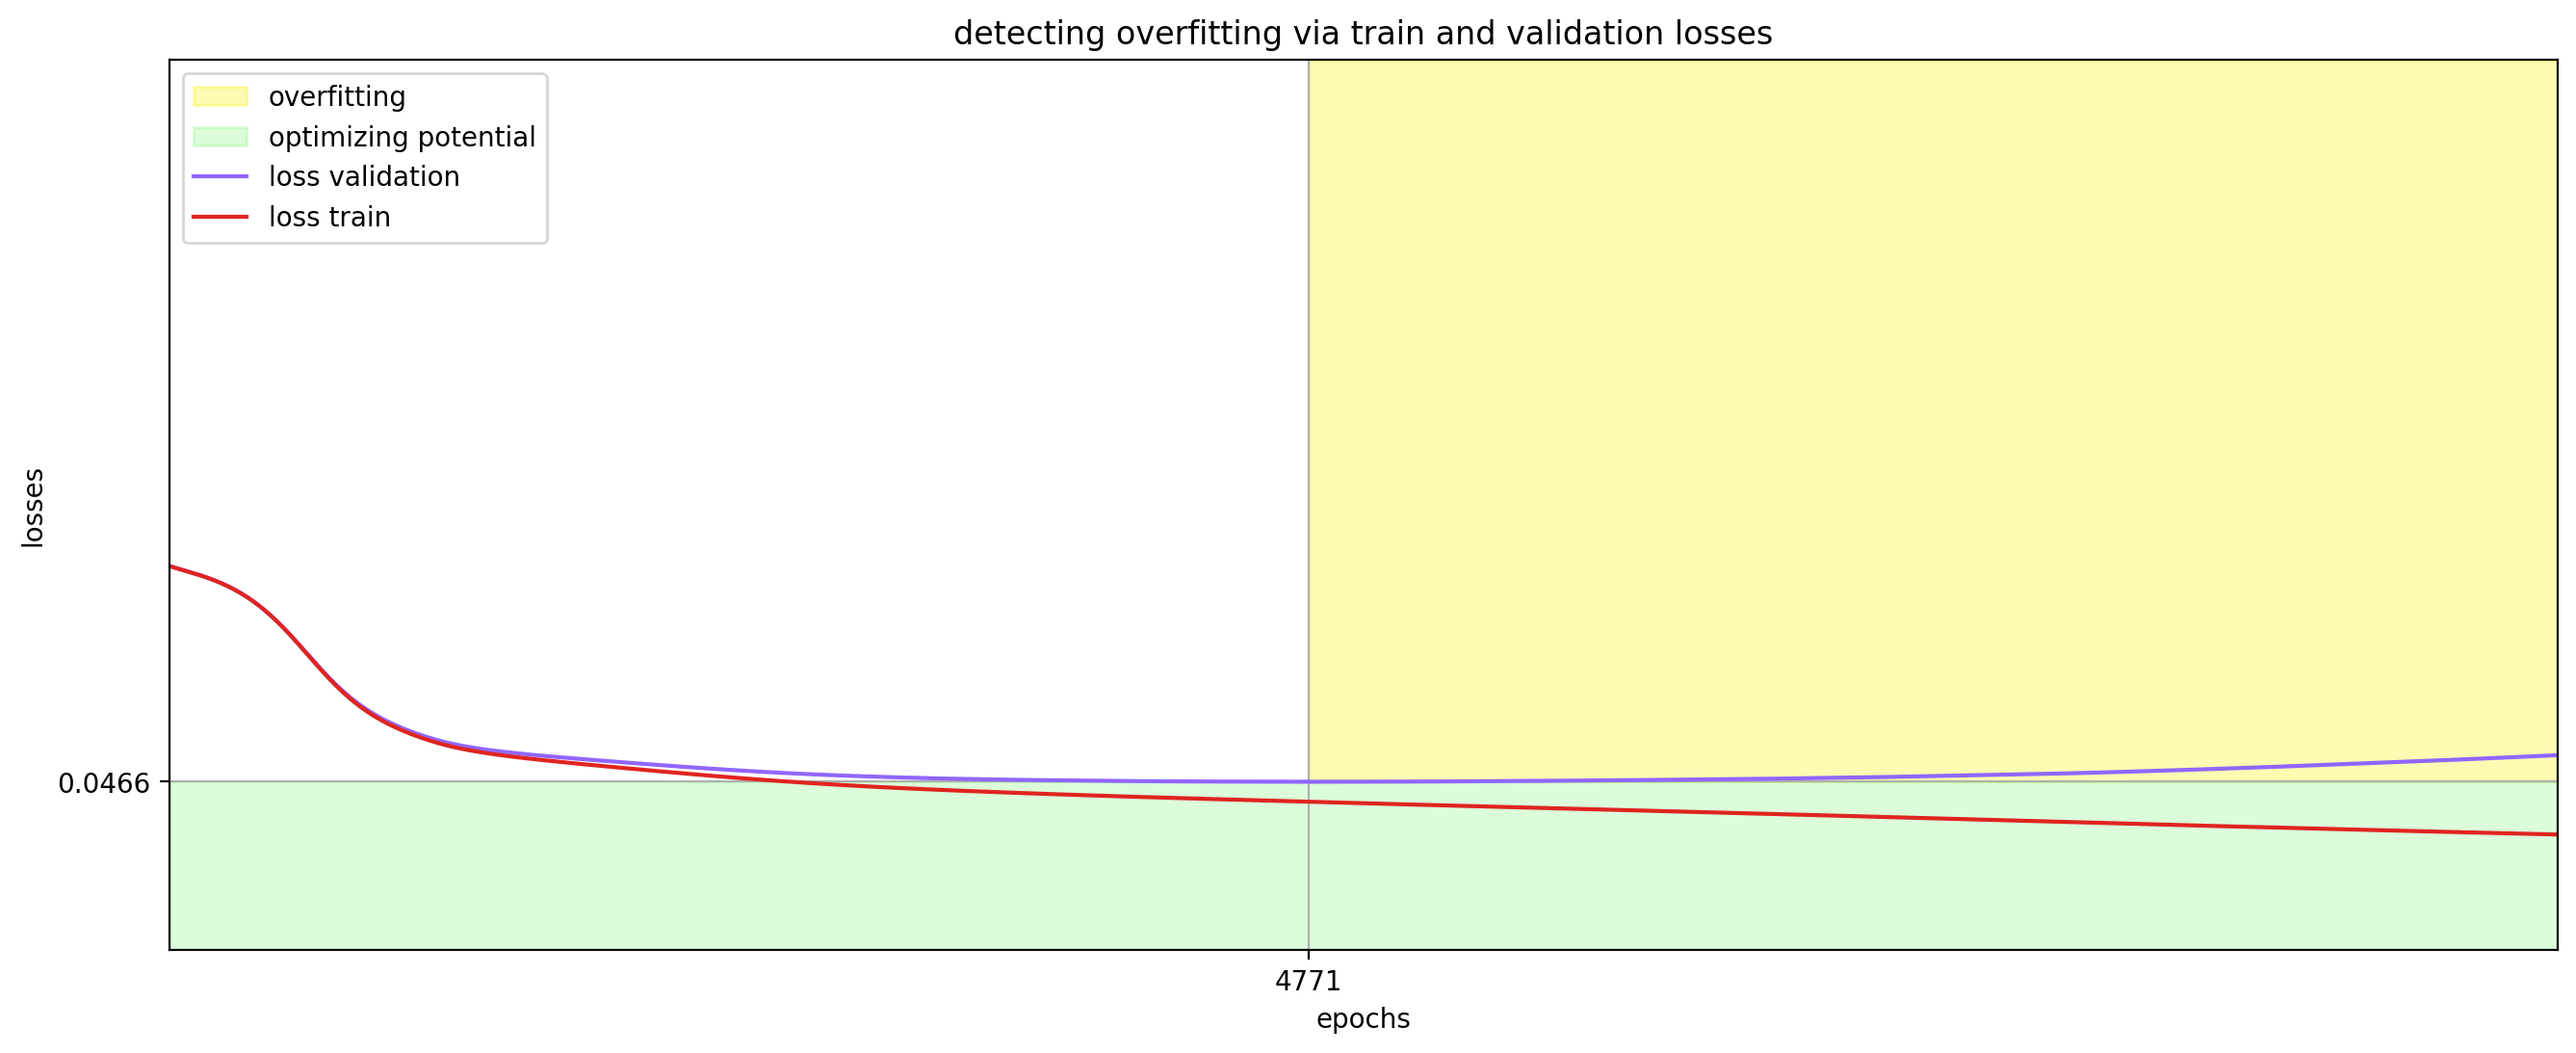

In [12]:
# visualize score
ymin = np.min(loss_val_arr) - 0.05
ymax = np.max(loss_val_arr) + 0.15
plt.figure(figsize=(16, 6), dpi=200)
plt.title("detecting overfitting via train and validation losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.axvspan(
    np.argmin(loss_val_arr),
    len(loss_val_arr),
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    1,
    color="#F5F200",
    alpha=0.3,
    label="overfitting",
)
plt.axvspan(
    0,
    len(loss_val_arr),
    0,
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    color="#52F748",
    alpha=0.2,
    label="optimizing potential",
)
plt.plot(loss_val_arr, color="#9166FF", label="loss validation")
plt.plot(loss_train_arr, color="#E02420", label="loss train")
plt.ylim(ymin, ymax)
plt.xlim(0, len(loss_val_arr))
plt.xticks([np.argmin(loss_val_arr)])
plt.yticks([np.min(loss_val_arr)])
plt.grid()
plt.legend()
plt.show()

Wie wir hier erkennen können, passiert nach einer bestimmten Zahl Iterationen overfitting, da der Loss Wert unseres Validierungsdatensatzes steigt, anstatt zu sinken. Um dies zu bekämpfen, muss das Modell selbst erkennen, dass Overfitting stattfindet und frühzeitig abbrechen. Dafür implemntieren wir ein Early Stopping, welches überprüft, ob der letzte Loss Wert kleiner ist, als der aktuelle. Falls dies der Fall ist, hört das Modell auf zu trainieren.

In [13]:
# create model
model = Gabonisator(X.shape[1], y.shape[1])

# define learning rate, loss function and optimizer
learning_rate = 0.00003
lossf = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

# loss tracker
loss_train_arr = []
loss_val_arr = []

# define iterations and iterate (training)
n_epochs = 10000
for epoch in range(n_epochs):
    # forward prop
    y_pred = model(X_train_pytorch)
    # loss function
    loss_train = lossf(y_pred, y_train_pytorch)
    # back prop
    loss_train.backward()
    # update params with optimizer
    optim.step()
    # empty gradients
    optim.zero_grad()

    # forward prop val data
    y_pred_val = model(X_val_pytorch)
    # get loss of validation data
    loss_val = lossf(y_pred_val, y_val_pytorch)
    # save losses
    loss_train_arr.append(loss_train.item())
    loss_val_arr.append(loss_val.item())

    # loss val goes up too much -> EarlyStop
    if np.round(np.min(loss_val_arr), 4) != np.round(loss_val.item(), 4):
        print("Early Stopping!")
        break

    # print info every 500 epochs
    if (epoch + 1) % 500 == 0:
        print(
            f"Epoch: {(epoch + 1): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f}"
        )

# print final data
with torch.no_grad():
    accuracy = (
        (model(X_val_pytorch).argmax(axis=1) == y_val_pytorch.argmax(axis=1)).sum() / y_val.shape[0]
    ).item()
    print("---")
    print(f"Final Run")
    print(
        f"Epoch: {(epoch): >5}/{n_epochs} | Loss train: {loss_train_arr[-1]:.4f} | Loss val: {loss_val_arr[-1]:.4f} | Score: {accuracy:.4f}"
    )


Epoch:   500/10000 | Loss train: 0.0848 | Loss val: 0.0849
Epoch:  1000/10000 | Loss train: 0.0585 | Loss val: 0.0590
Epoch:  1500/10000 | Loss train: 0.0537 | Loss val: 0.0547
Epoch:  2000/10000 | Loss train: 0.0508 | Loss val: 0.0524
Epoch:  2500/10000 | Loss train: 0.0481 | Loss val: 0.0501
Epoch:  3000/10000 | Loss train: 0.0457 | Loss val: 0.0484
Epoch:  3500/10000 | Loss train: 0.0440 | Loss val: 0.0474
Epoch:  4000/10000 | Loss train: 0.0428 | Loss val: 0.0469
Epoch:  4500/10000 | Loss train: 0.0418 | Loss val: 0.0467
Epoch:  5000/10000 | Loss train: 0.0408 | Loss val: 0.0466
Epoch:  5500/10000 | Loss train: 0.0399 | Loss val: 0.0466
Early Stopping!
---
Final Run
Epoch:  5662/10000 | Loss train: 0.0396 | Loss val: 0.0467 | Score: 0.6256


Jetzt visualisieren wir unsere Ergebnisse anhand der gleichen Visualisierung wie vorhin.

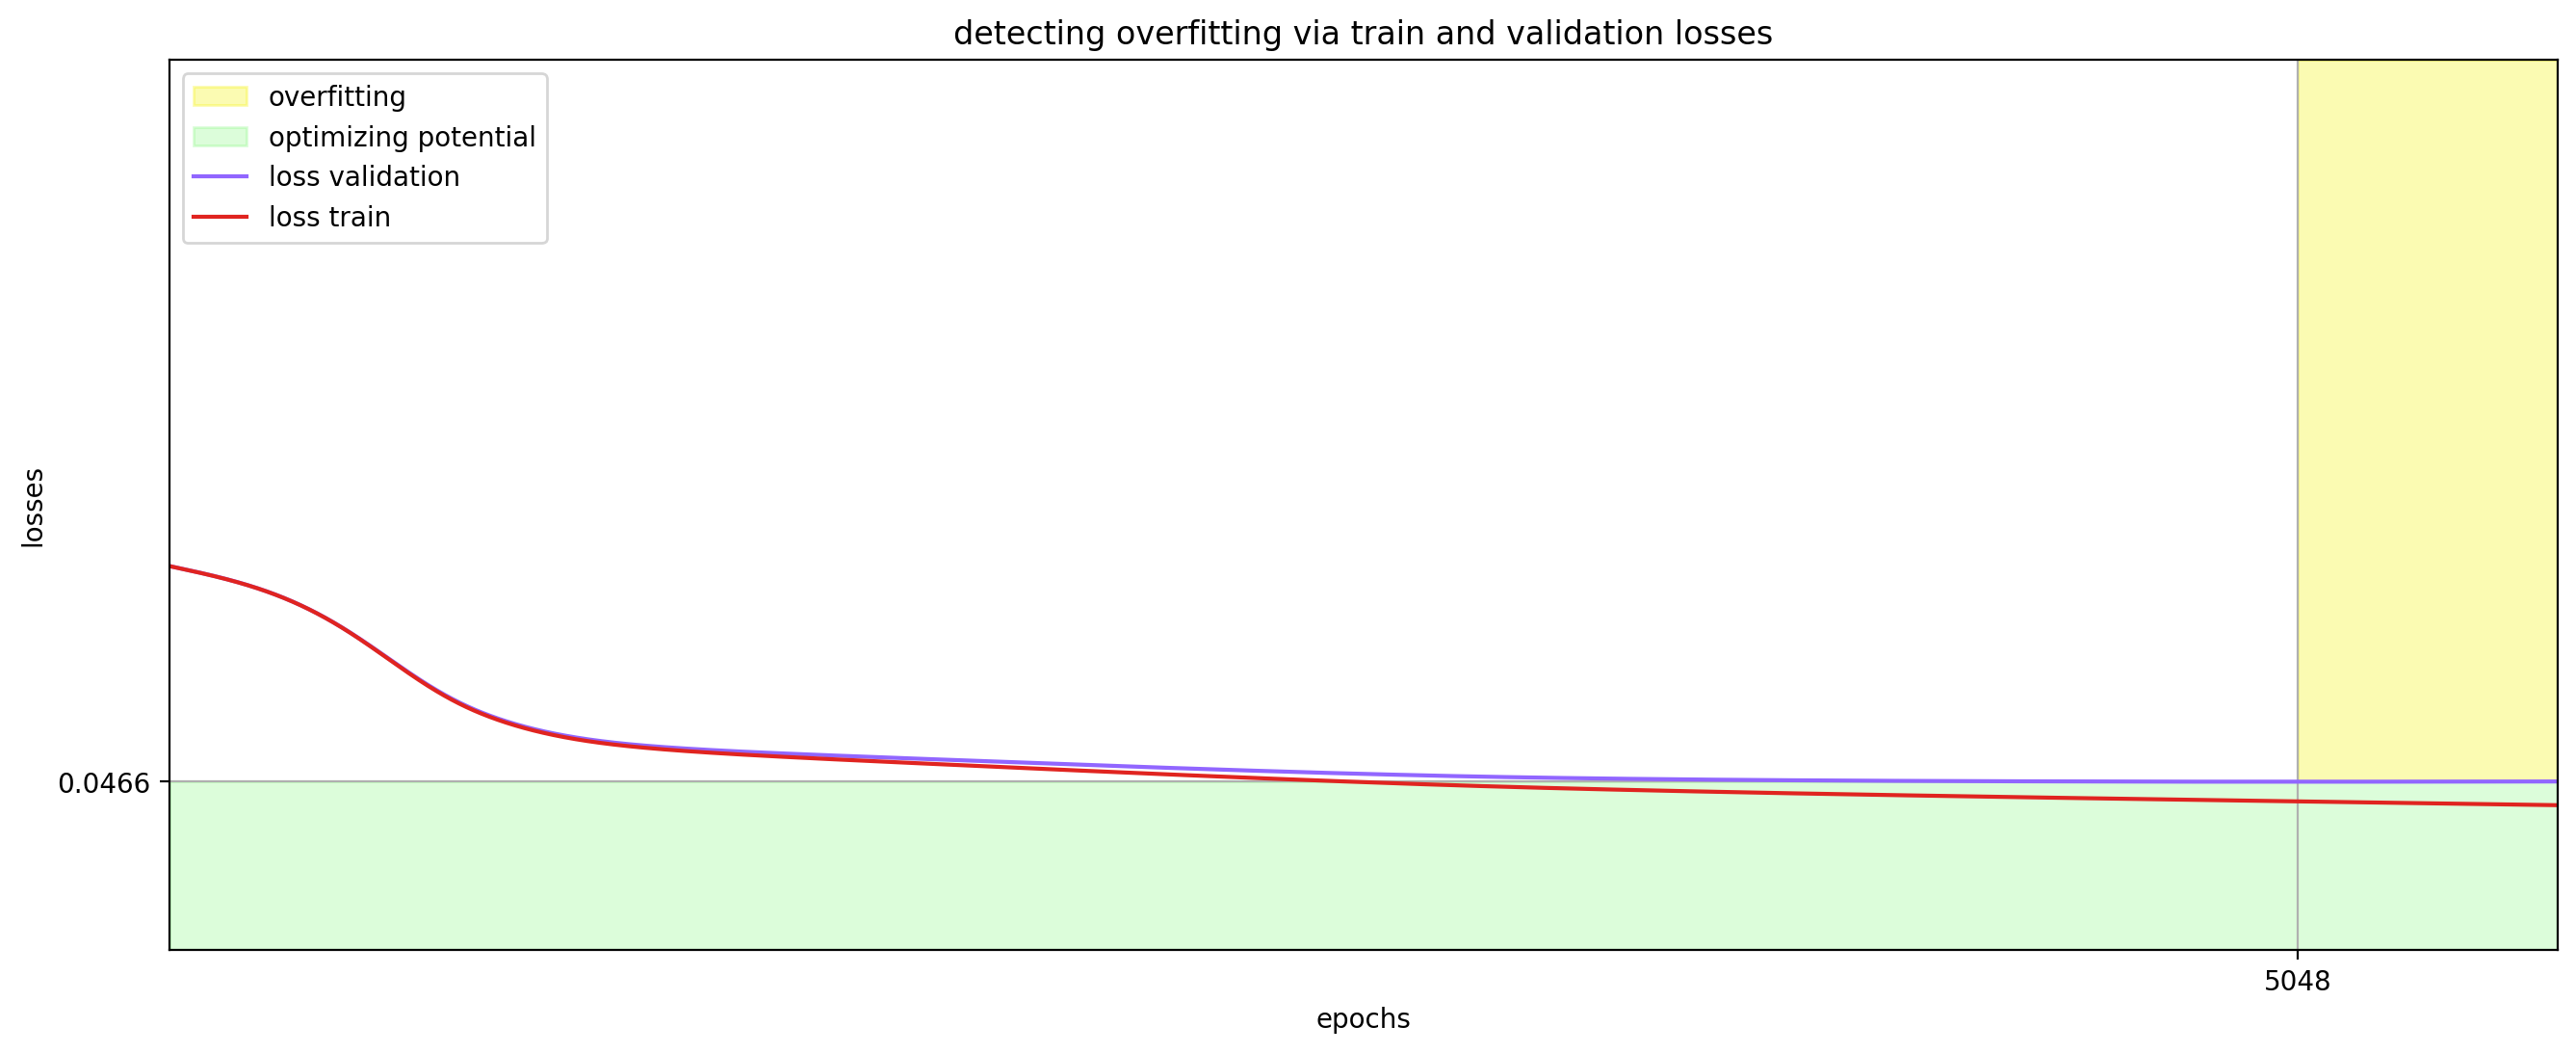

In [14]:
# visualize score
ymin = np.min(loss_val_arr) - 0.05
ymax = np.max(loss_val_arr) + 0.15
plt.figure(figsize=(16, 6), dpi=200)
plt.title("detecting overfitting via train and validation losses")
plt.xlabel("epochs")
plt.ylabel("losses")
plt.axvspan(
    np.argmin(loss_val_arr),
    len(loss_val_arr),
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    1,
    color="#F5F200",
    alpha=0.3,
    label="overfitting",
)
plt.axvspan(
    0,
    len(loss_val_arr),
    0,
    (np.min(loss_val_arr) - ymin) / (ymax - ymin),
    color="#52F748",
    alpha=0.2,
    label="optimizing potential",
)
plt.plot(loss_val_arr, color="#9166FF", label="loss validation")
plt.plot(loss_train_arr, color="#E02420", label="loss train")
plt.ylim(ymin, ymax)
plt.xlim(0, len(loss_val_arr))
plt.xticks([np.argmin(loss_val_arr)])
plt.yticks([np.min(loss_val_arr)])
plt.grid()
plt.legend()
plt.show()

In [15]:
def get_score_for_continous_multioutput(y_pred_continous, y_true, score_type):
    '''
    Compute different scores where y_pred is a continuous-multioutput

    Returns
    -------
    f1_score or precision_score or recall_scource from sklearn.metrics
    '''
    indices = [np.argmax(x) for x in y_pred_continous]
    zeros = [np.zeros(len(x)) for x in y_pred_continous]
    y_pred = list()
    for x, ind in zip(zeros, indices):
        x[ind] = 1
        y_pred.append(x)
    if score_type == "f1_score":
        return f1_score(y_true, y_pred, average="weighted", zero_division=1)
    elif score_type == "precision_score":
        return precision_score(y_true, y_pred, average="weighted", zero_division=1)
    elif score_type == "recall_score":
        return recall_score(y_true, y_pred, average="weighted", zero_division=1)

In [16]:
y_pred_np = model(X_val_pytorch).detach().numpy()
y_val_np = y_val_pytorch.numpy()

In [17]:
print(
    """
    Unser {} bricht jetzt frühzeitig ab und verhindert somit overfitting.\n
    Unsere {} ist mit diesem Modell ca. {}%,\n
    Unser {} ist mit diesem Modell ca. {}%,\n
    Unsere {} ist mit diesem Modell ca. {}%,\n
    Unser {} ist mit diesem Modell ca. {}%
    """.format(
        model.__class__.__name__,
        "Accuracy",
        np.round(accuracy, 2),
        "F1 Score",
        np.round(get_score_for_continous_multioutput(y_pred_np, y_val_np, "f1_score"), 2),
        "Precision",
        np.round(get_score_for_continous_multioutput(y_pred_np, y_val_np, "precision_score"), 2),
        "Recall",
        np.round(get_score_for_continous_multioutput(y_pred_np, y_val_np, "recall_score"), 2)
    )
)


    Unser Gabonisator bricht jetzt frühzeitig ab und verhindert somit overfitting.

    Unsere Accuracy ist mit diesem Modell ca. 0.63%,

    Unser F1 Score ist mit diesem Modell ca. 0.55%,

    Unsere Precision ist mit diesem Modell ca. 0.63%,

    Unser Recall ist mit diesem Modell ca. 0.63%
    


## K Neighbors Classifier

In [18]:
data_ = pd.read_csv("https://raw.githubusercontent.com/Immobilienrechner-Challenge/data/main/clean.csv")
data_ = data_[['price', 'zip_code', 'living_space', 'rooms', 'type']].copy()

Da unser Datensatz nur wenig NAs hat, verwerfen wir diese Observationen. Uns bleiben noch um die 11000 Datensätze.

In [19]:
data_ = data_.dropna()
len(data_)

10548

Unsere Daten spalten wir danach in Features und Zielvariablen

In [20]:
y_cols = ["type"]
X_cols = list(set(data_.columns) - set(y_cols))

X = data_[X_cols].values
y = data_[y_cols].values.ravel()

Unsere Daten unterteilen wir danach auf Trainings- und Validierungsdaten.

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

Hier trainieren wir mehrere Modelle, welche wir anhand verschiedener Anzahl Neighbors erstellen. Für jedes Modell berechnen wir die Accuracy und speichern diese ab.

In [22]:
accuracies = np.array(
    [
        (i, KNeighborsClassifier(i).fit(X_train, y_train).score(X_val, y_val)) for i in tqdm(range(1, 50))
    ]
)

  0%|          | 0/49 [00:00<?, ?it/s]

Um zu entscheiden, wieviel Neighbors man für das Modell nehmen soll, visualisieren wir hier die Accuracy für jeden Wert.

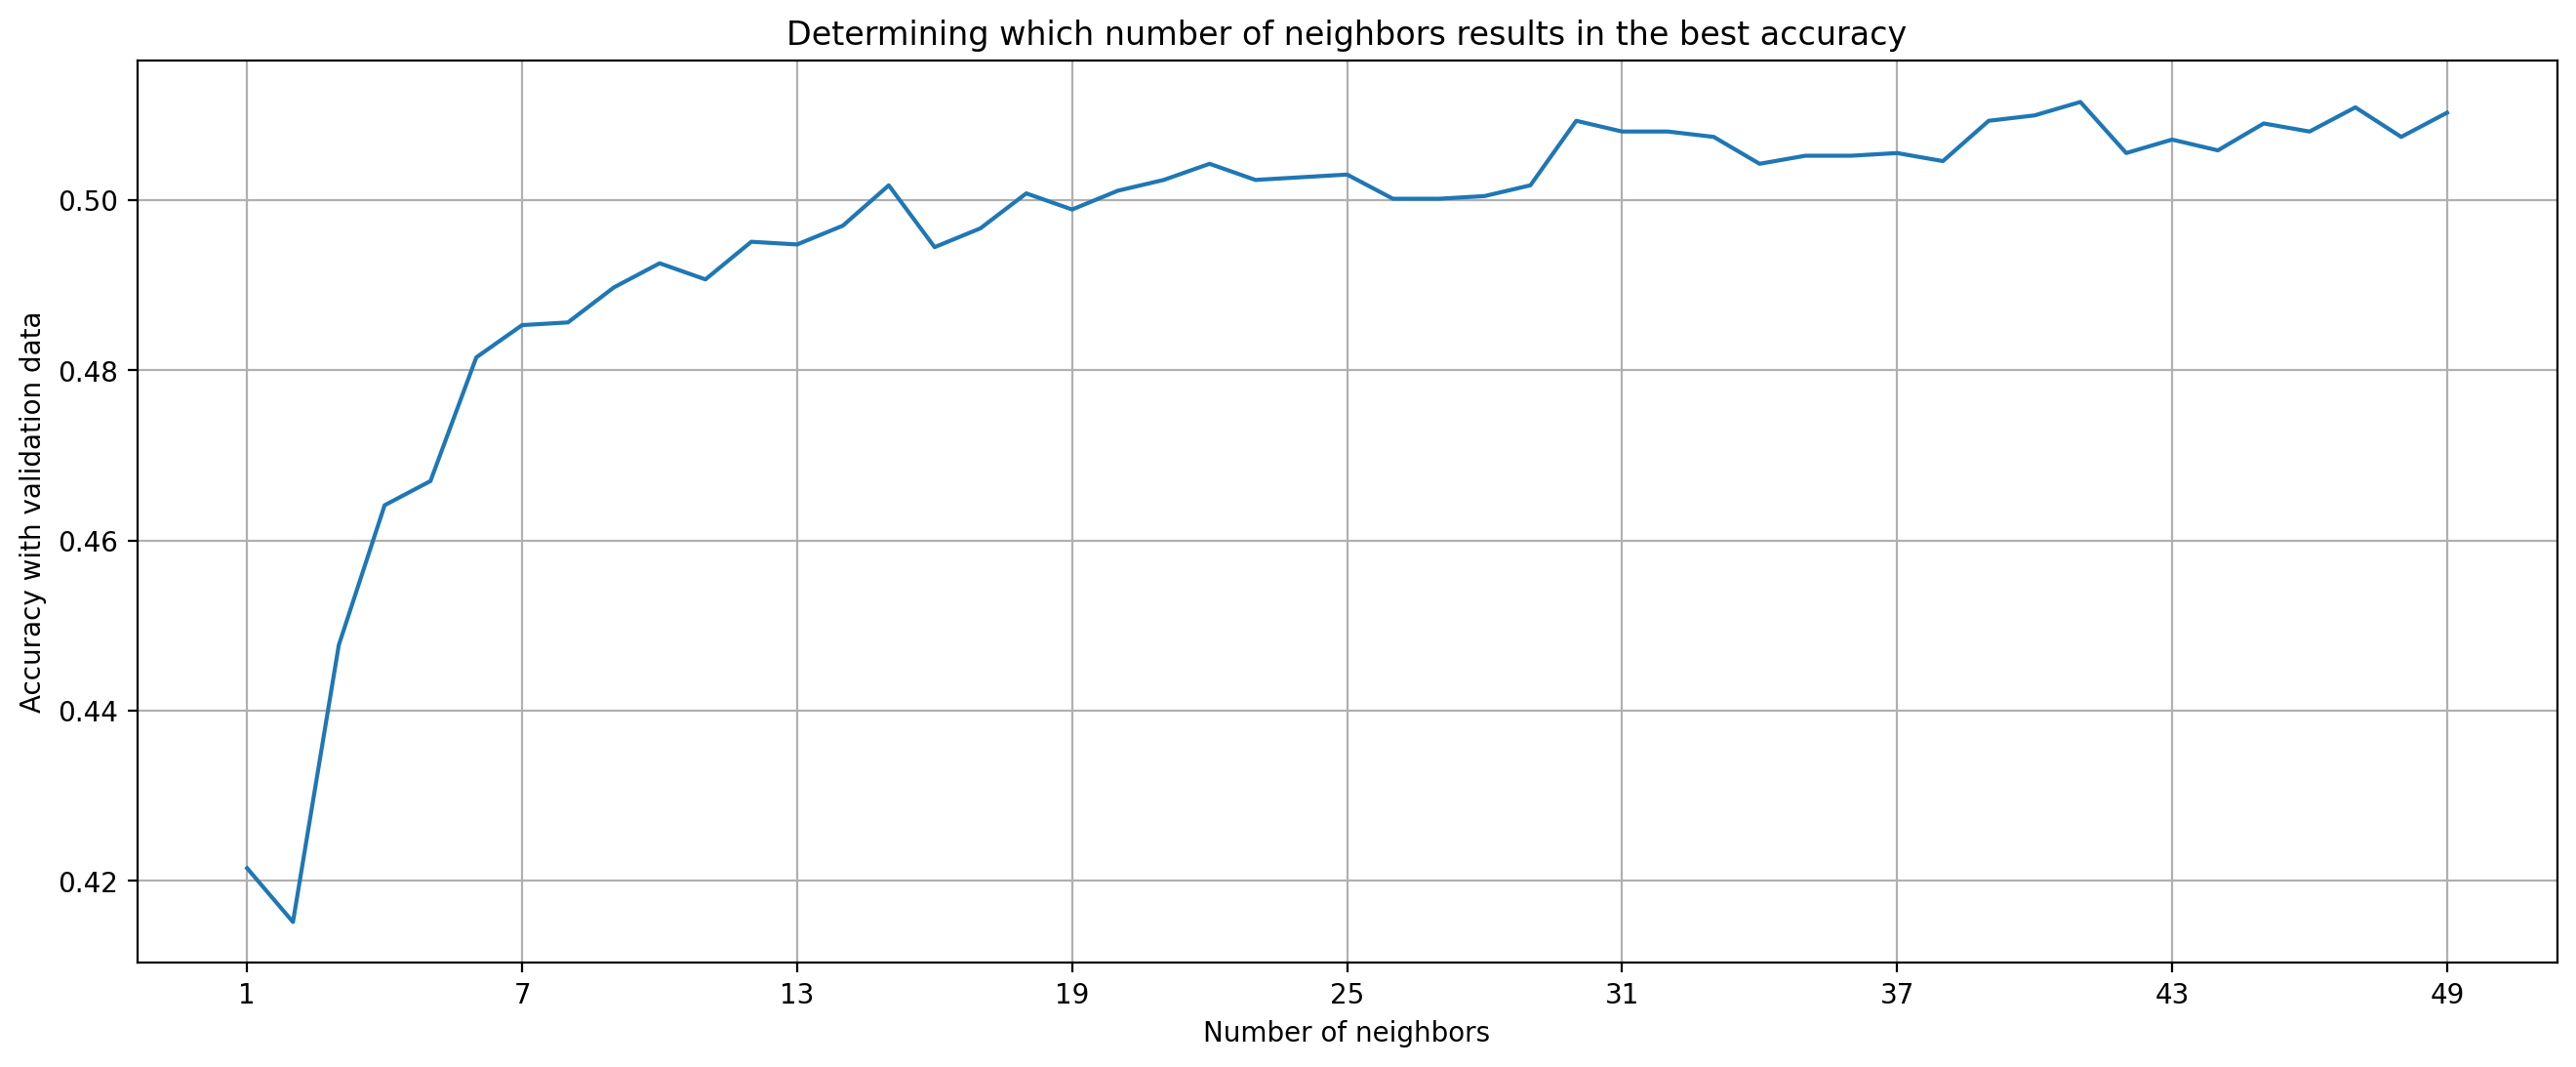

In [23]:
plt.figure(figsize=(16, 6), dpi=200)
plt.title("Determining which number of neighbors results in the best accuracy")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy with validation data")
plt.plot(accuracies[:,0], accuracies[:,1])
plt.xticks(np.linspace(1, 49, 9))
plt.grid()
plt.show()

In [35]:
neighbors = int(accuracies[:, :1].ravel()[np.argmax(accuracies[:, 1:])])
clf = OneVsRestClassifier(KNeighborsClassifier(neighbors)).fit(X_train, y_train)
accuracy = clf.score(X_val, y_val)
f1score = f1_score(y_val, clf.predict(X_val), average="weighted", zero_division=1)
precision = precision_score(y_val, clf.predict(X_val), average="weighted", zero_division=1)
recall = recall_score(y_val, clf.predict(X_val), average="weighted", zero_division=1)

In [36]:
print(
    '''
    Aus dem obigen Plot kann man sehen, welches Modell die höchste Accuracy hat.\n
    Wir setzen für den {} die Anzhal {} = {}\n
    und erhalten damit eine {} von ca. {}%,\n
    Unser {} ist mit diesem Modell ca. {}%,\n
    Unsere {} ist mit diesem Modell ca. {}%,\n
    Unser {} ist mit diesem Modell ca. {}%
    '''.format(
        model.__class__.__name__,
        "neighbors",
        neighbors,
        "Accuracy",
        np.round(accuracy, 2),
        "F1 Score",
        np.round(f1score, 2),
        "Precision",
        np.round(precision, 2),
        "Recall",
        np.round(recall, 2)
    )
)


    Aus dem obigen Plot kann man sehen, welches Modell die höchste Accuracy hat.

    Wir setzen für den RandomForestClassifier die Anzhal neighbors = 41

    und erhalten damit eine Accuracy von ca. 0.51%,

    Unser F1 Score ist mit diesem Modell ca. 0.43%,

    Unsere Precision ist mit diesem Modell ca. 0.61%,

    Unser Recall ist mit diesem Modell ca. 0.51%
    


In [182]:
y_pred_knn = clf.predict(X_val)
knn_evaluator = Evaluator(y_val, y_pred_knn, classes)

knn_evaluator.print_scores()

Recall: 0.5096366508688783
Precision: 0.6065741488046448
F1: 0.4277761885255238
Matthews Correlation Coefficient: 0.1955866472555695
Accuracy: 0.5096366508688783


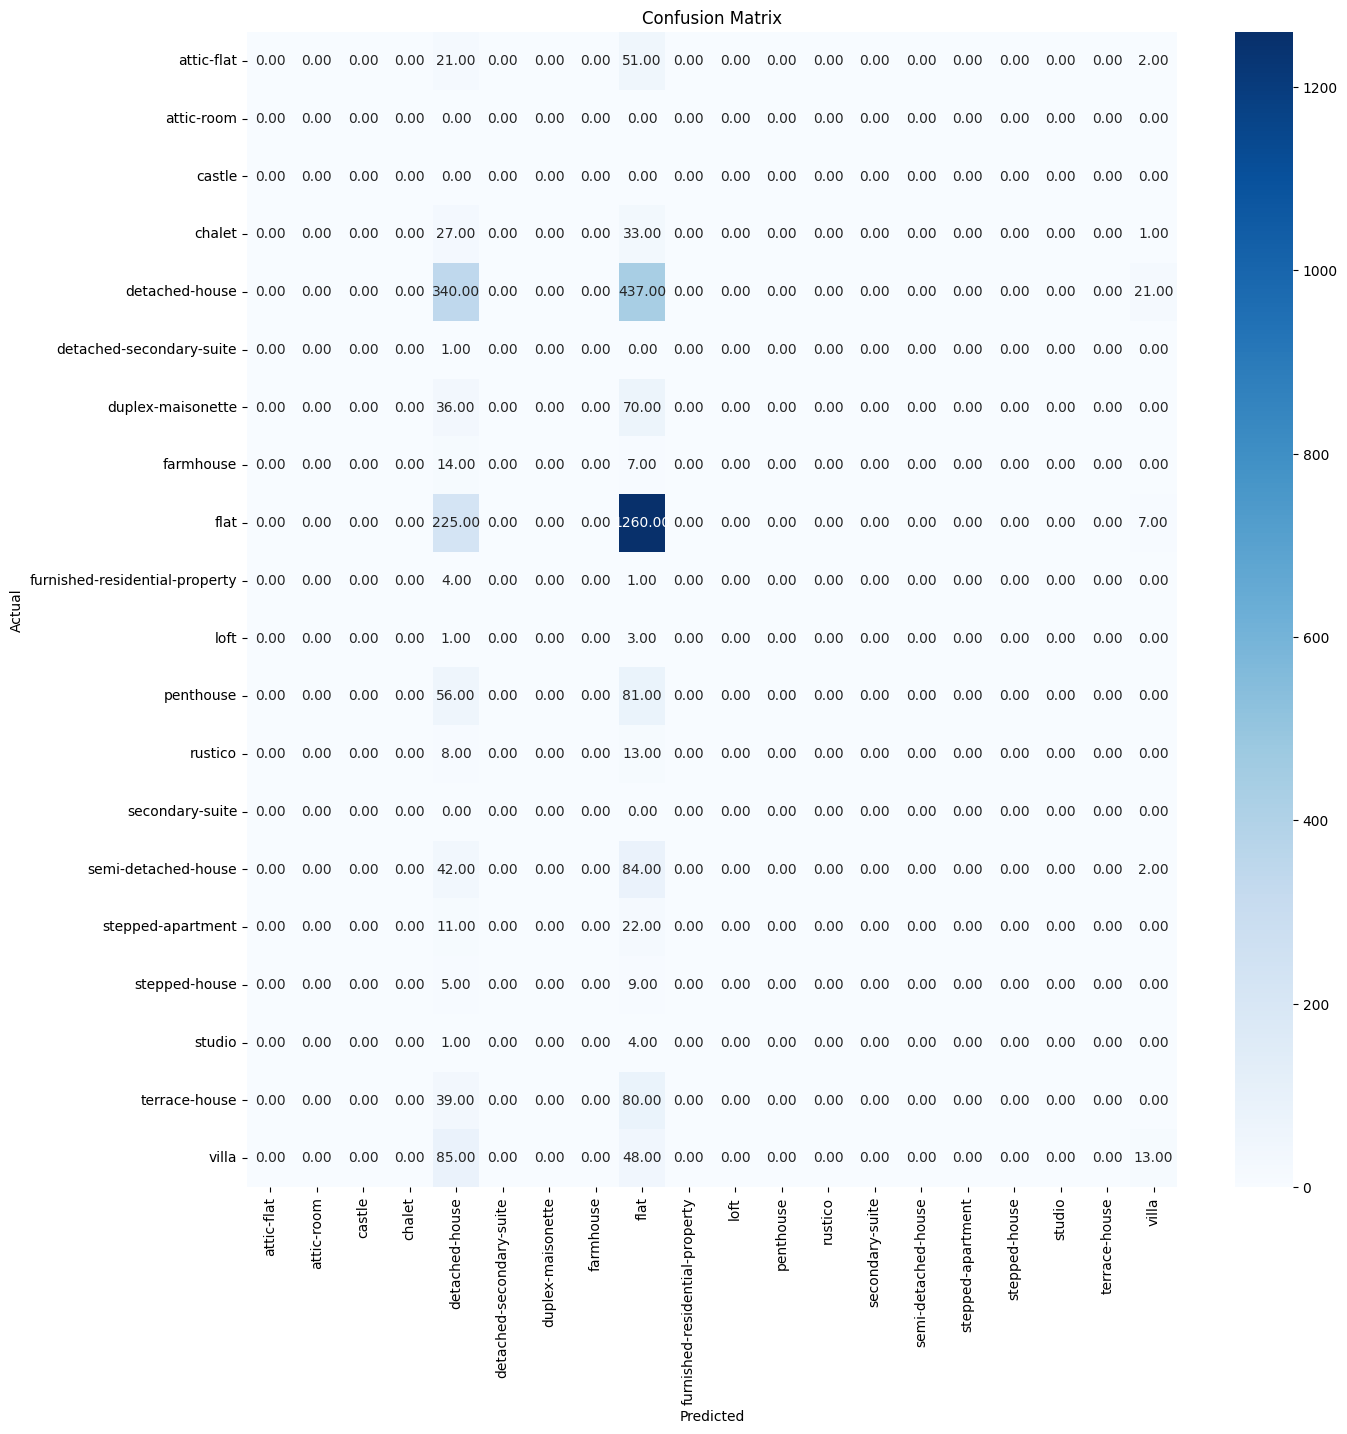

In [156]:
knn_evaluator.confusion_plot()

In [183]:
knn_evaluator.calculate_roc_auc(clf, X_val)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1018: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


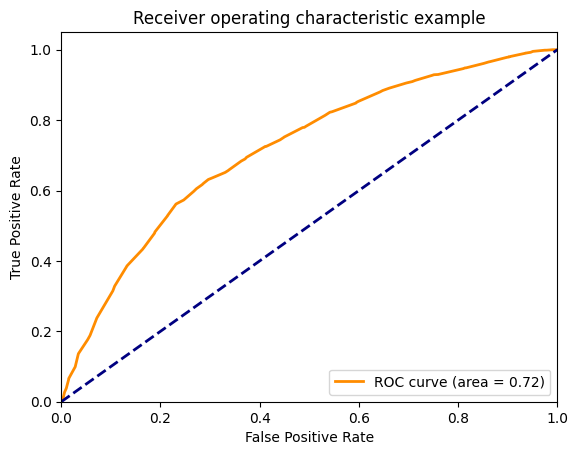

In [159]:
knn_evaluator.plot_roc_curve(8)

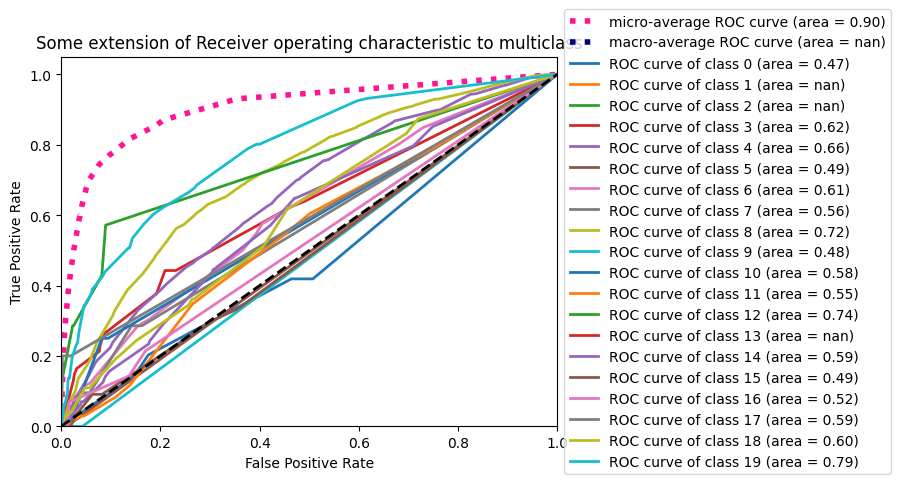

In [184]:
knn_evaluator.plot_all_roc()

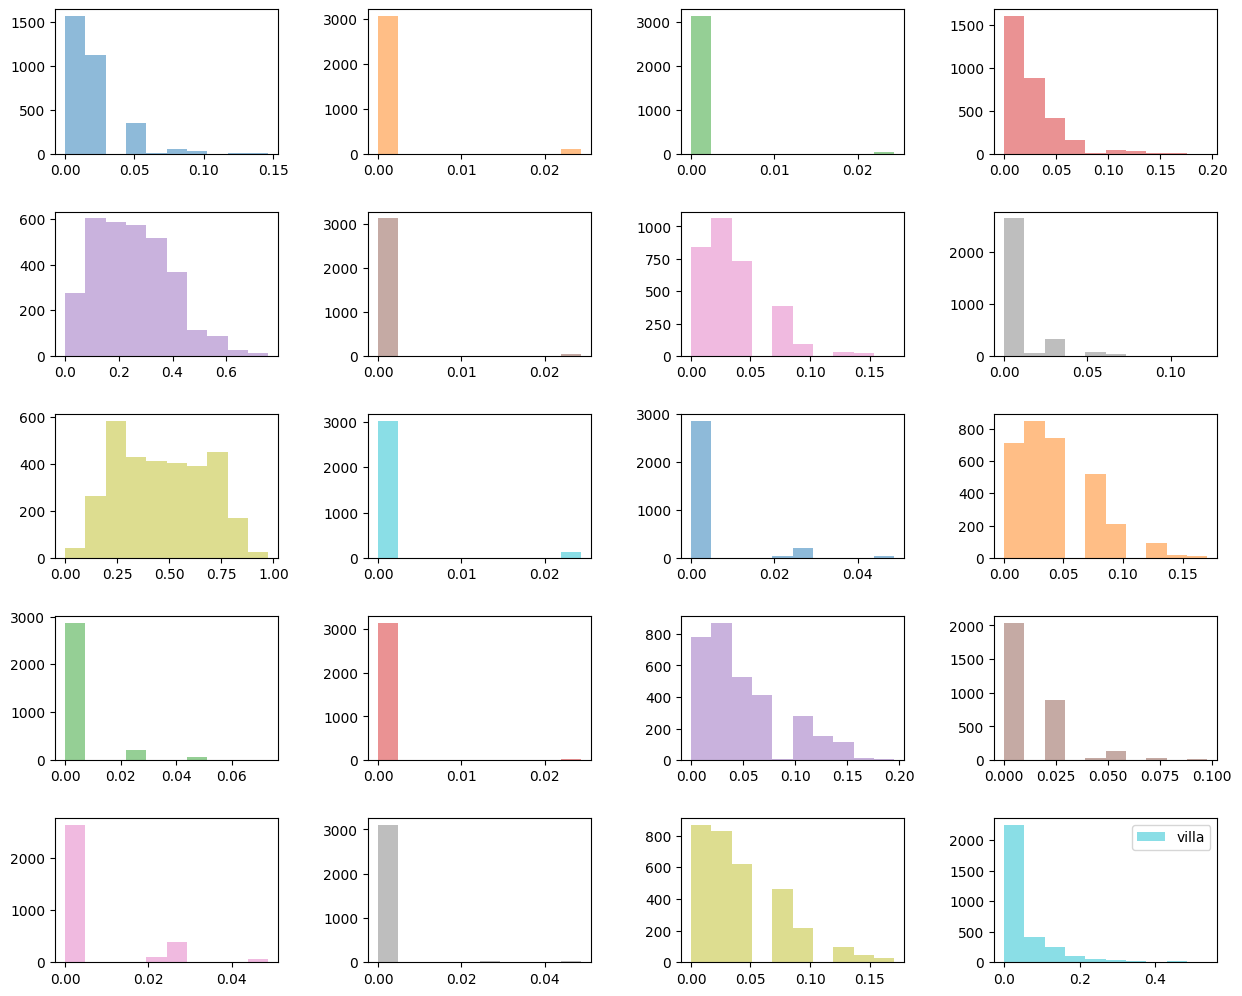

In [185]:
knn_evaluator.plot_histograms()

## Random Forest Classifier

Um zu entscheiden welche Parameter in Frage kommen, probieren wir es zuerst mit "RandomizedSearchCV" und danach mit "GridSearchCV"

Random Hyperparameter Grid:<br />
Wir erstellen zuerst einen Hyperparameter Grid,<br />
und wählen nach dem Zufallsprinzip Kombinationen, um eine breite Palette von Werten auszuprobieren.<br />
Danach instanzieren wir random search auf unsere Daten und wählen n_iter für die Nummer der verschiedenen<br />
Kombinationen sowie cv für die Nummer der folds für Cross Validation.

In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Nummer der Bäume im Random Forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)]
# Anzahl der Features, die bei jedem Split berücksichtigt werden
max_features = ['sqrt']
# Maximale Anzahl an Ebenen im Baum
max_depth = [int(x) for x in np.linspace(1, 11, num = 1)]
max_depth.append(None)
# Mindestanzahl an Samples, die benötigt werden, um einen Knoten zu splitten
min_samples_split = [2, 5, 10]
# Mindestanzahl an Samples, die benötigt werden, um einen Blattknoten zu erstellen
min_samples_leaf = [1, 2, 4]
# Methode, um Samples für das Training jedes Baumes auszuwählen
bootstrap = [True, False]
# Erstelle das zufällige Grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}
# Verwende das zufällige Grid, um die besten Hyperparameter zu finden
# Erstelle zuerst das Basismodell, das angepasst werden soll
random_forest_classifier = RandomForestClassifier()
# Zufällige Suche nach Parametern, mit 3-facher Kreuzvalidierung,
# Suche über 100 verschiedene Kombinationen und verwende alle verfügbaren Kerne
rfc_random = RandomizedSearchCV(
    estimator = random_forest_classifier,
    param_distributions = random_grid,
    n_iter = 50, 
    cv = 2, 
    verbose=0, 
    random_state=42,
    n_jobs = -1
)
# Passe das zufällige Suchmodell an
rfc_random.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 14, 18, 23, 27, 32,
                                                         36, 41, 45, 50]},
                   random_state=42)

In [27]:
rfc_random.best_params_

{'n_estimators': 41,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

Grid Search mit Cross Validation

In [28]:
from sklearn.model_selection import GridSearchCV
# Erstelle das Parametergrid basierend auf den Ergebnissen der zufälligen Suche
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [1, None],
    'max_features': ["sqrt"],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 14, 18, 23, 27, 32, 36, 41, 45, 50]
}
# Erstelle ein Basismodell
rf = RandomForestClassifier()
# Erstelle das Grid-Suchmodell
grid_search = GridSearchCV(
    estimator = rf, 
    param_grid = param_grid, 
    cv = 2, 
    n_jobs = -1, 
    verbose = 0
)
# Passe die Grid-Suche an die Daten an
grid_search.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [1, None],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 14, 18, 23, 27, 32, 36, 41, 45,
                                          50]})

In [29]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 27}

Berechne die höchste Accuracy für beide Hyperparameter Optimierungen

In [30]:
rfc_random_accuracy = rfc_random.score(X_val, y_val)
grid_accuracy = grid_search.best_estimator_.score(X_val, y_val)

Printe alle erforderlichen Scores

In [37]:
n_estimators = max(grid_search.best_params_["n_estimators"], rfc_random.best_params_["n_estimators"])
model = grid_search.best_estimator_
accuracy = max(rfc_random_accuracy, grid_accuracy)
f1score = f1_score(y_val, model.predict(X_val), average="weighted", zero_division=1)
precision = precision_score(y_val, model.predict(X_val), average="weighted", zero_division=1)
recall = recall_score(y_val, model.predict(X_val), average="weighted", zero_division=1)

In [38]:
print(
    '''
    Aus den obigen Überlegungen setzen wir\n 
    für den {} den Parameter {} = {} (number of trees in the model)\n
    und erhalten damit eine {} von ca. {}%,\n
    unser {} ist mit diesem Modell ca. {}%,\n
    unsere {} ist mit diesem Modell ca. {}%,\n
    unser {} ist mit diesem Modell ca. {}%
    '''.format(
        model.__class__.__name__,
        "n_estimators",
        n_estimators,
        "Accuracy",
        np.round(accuracy, 2),
        "F1 Score",
        np.round(f1score, 2),
        "Precision",
        np.round(precision, 2),
        "Recall",
        np.round(recall, 2)
    )
)


    Aus den obigen Überlegungen setzen wir
 
    für den RandomForestClassifier den Parameter n_estimators = 41 (number of trees in the model)

    und erhalten damit eine Accuracy von ca. 0.65%,

    unser F1 Score ist mit diesem Modell ca. 0.57%,

    unsere Precision ist mit diesem Modell ca. 0.63%,

    unser Recall ist mit diesem Modell ca. 0.64%
    
